In [1]:
import numpy as np 
import pandas as pd
import json
from mplsoccer.pitch import Pitch, VerticalPitch


path = "C:/Users/brand/desktop/events/events_England.json" 

with open(path) as f:
    data = json.load(f)

train = pd.DataFrame(data)


path2 = "C:/Users/brand/desktop/players.json" 


with open(path2) as f:
    play = json.load(f)

players = pd.DataFrame(play)

lst = ['events_France.json','events_Germany.json','events_Italy.json','events_Spain.json']
pathway = "C:/Users/brand/desktop/events/"

for country in lst:
    with open(pathway + country) as f:
        datal = json.load(f)
        tl = pd.DataFrame(datal)
        train = pd.concat([train,tl],ignore_index=True)




#pd.unique(train['subEventName'])
shots = train[train['subEventName'] == 'Shot']

print(len(shots))

shots_model = pd.DataFrame(columns=["Goal","X","Y"], dtype=object)

for i,shot in shots.iterrows():
    
    
    shots_model.at[i,'Header'] = 0
    for tag in shot['tags']:
        if tag['id'] == 403:
            shots_model.at[i,'Header'] = 1
    
    
    #take distance from center of goal at y = 50, x position of goal is always 100
    shots_model.at[i,'X'] = 100-shot['positions'][0]['x']
    shots_model.at[i,'Y'] = shot['positions'][0]['y']
    shots_model.at[i,'C'] = abs(shot['positions'][0]['y'] - 50)
        
    #distance in meters
        
    x = shots_model.at[i,'X']* 105/100
    y = shots_model.at[i,'C']* 65/100
    shots_model.at[i,'Distance'] = np.sqrt(x**2 + y**2)
        
    angle = np.arctan(7.32 * x / (x**2 + y**2 - (7.32/2)**2))
        
    if angle < 0:
        angle = np.pi + angle
        
    shots_model.at[i,'Angle'] = angle
        
    #goal check
    shots_model.at[i,'Goal'] = 0
    shots_model.at[i,'Counter Attack'] = 0
    shots_model.at[i, 'Blocked'] = 0
    shots_model.at[i, 'Right Foot'] = 0
    shots_model.at[i,'wyId'] = shot['playerId']
    
    if shot['matchPeriod'] == '1H':
        shots_model.at[i, 'First Half'] = 1
    
    else:
        shots_model.at[i,'First Half'] = 0
        
    for tags in shot['tags']:
        if tags['id'] == 101:
            shots_model.at[i,'Goal'] = 1
            
        if tags['id'] == 1901:
            shots_model.at[i, 'Counter Attack'] = 1
        
        if tags['id'] == 2101:
            shots_model.at[i, 'Blocked'] = 1
        
        if tags['id'] == 402:
            shots_model.at[i, 'Right Foot'] = 1
            
            
        
shots_model['angle_degrees'] = shots_model['Angle'] * 180 / np.pi

shots_model = shots_model.merge(players, left_on = 'wyId' , right_on = 'wyId')

for i,shot in shots_model.iterrows():
    shots_model.at[i, 'strong foot'] = 0
    
    if shot['Right Foot'] == 1:
        if shot['foot'] == 'right':
            shots_model.at[i, 'strong foot'] = 1
    
    elif shot['Right Foot'] == 0:
        if shot['foot'] == 'left':
            shots_model.at[i, 'strong foot'] = 1


pitch = Pitch(pitch_color ='black', line_color = 'white', stripe=False,pitch_type='wyscout')

fig,ax = pitch.draw(figsize=(10,8))

df = shots_model.loc[shots_model['Goal'] == 1]
xpos = df["X"]
ypos = df["Y"]

df_nongoals = shots_model.loc[shots_model['Goal'] == 0]
xpos2 = df_nongoals["X"]
ypos2 = df_nongoals["Y"]



head = shots_model[shots_model['Header'] == 1]
counter = shots_model[shots_model['Counter Attack'] == 1]
strong = shots_model[shots_model['strong foot'] == 1]
first = shots_model[shots_model['First Half'] == 1]
head_df = head.loc[head['Goal'] == 1]
strong_goal = strong.loc[strong['Goal'] == 1]

headed_goals = len(head_df)

40461


In [10]:
from sklearn.model_selection import train_test_split

X_full = shots_model[["Header","Distance", "Angle","Counter Attack","strong foot", "First Half"]]
y_full = shots_model[["Goal"]]
y_full['Goal'] = y_full['Goal'].astype(int)
print(X_full.head())

X_train,X_test,y_train,y_test = train_test_split(X_full,y_full,test_size = 0.15,random_state=2)

X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.176, random_state=2)

   Header   Distance     Angle  Counter Attack  strong foot  First Half
0     0.0  13.891814  0.474451             0.0          1.0         1.0
1     0.0  13.711765  0.519737             0.0          1.0         1.0
2     0.0  14.778701  0.358683             0.0          0.0         0.0
3     0.0  15.243113  0.337590             0.0          1.0         0.0
4     0.0  19.602296  0.357062             0.0          1.0         1.0


C:\Users\brand\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [11]:
y_val = np.array(y_val.pop('Goal'))
y_test = np.array(y_test.pop('Goal'))
y_train = np.array(y_train.pop('Goal'))


X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
X_val = X_val.to_numpy()
print(X_train.shape)
print(y_train.shape)       

(28336, 6)
(28336,)


In [14]:
"""Class imbalance"""

negative,positive = np.bincount(y_full['Goal'])

print(positive/(negative+positive))


0.10556626625142122


In [4]:
"""Feed Forward Neural Network"""

'Feed Forward Neural Network'

In [15]:
import tensorflow as tf
from tensorflow import keras 
import sklearn 
from sklearn.preprocessing import StandardScaler

In [19]:
scaler = StandardScaler()
train_feats = scaler.fit_transform(X_train)

val_feats = scaler.transform(X_val)
test_feats = scaler.transform(X_test)


train_feats = np.clip(train_feats,-5,5)
val_feats = np.clip(val_feats,-5,5)
test_feats = np.clip(test_feats,-5,5)




In [198]:
boolean_train_labels = y_train != 0


METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(
            25, activation='relu',
            input_shape=(train_feats.shape[-1],)),
        keras.layers.Dense(
            25, activation='relu',
            input_shape=(train_feats.shape[-1],)),keras.layers.Dropout(0.5),
        
        keras.layers.Dense(1, activation='sigmoid',bias_initializer=output_bias),
  ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model


In [199]:
EPOCHS = 100
BATCH_SIZE = 256

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_prc',verbose=1,patience=10,mode='max',restore_best_weights=True)

model = make_model()
model.summary()

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_142 (Dense)           (None, 25)                175       
                                                                 
 dense_143 (Dense)           (None, 25)                650       
                                                                 
 dropout_30 (Dropout)        (None, 25)                0         
                                                                 
 dense_144 (Dense)           (None, 1)                 26        
                                                                 
Total params: 851
Trainable params: 851
Non-trainable params: 0
_________________________________________________________________


In [200]:
"""Initialize bias"""

orig_bias = np.log([positive/negative])
model = make_model(output_bias=orig_bias)



In [201]:
import os 
import tempfile

initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)


In [202]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_feats,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=100,
    validation_data=(val_feats, y_val), 
    verbose=0)

In [203]:
import matplotlib.pyplot as plt


def plot_loss(history, label):
  # Use a log scale on y-axis to show the wide range of values.
    plt.semilogy(history.epoch, history.history['loss'],
               'b', label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'],
               color='r', label='Val ' + label,
               linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

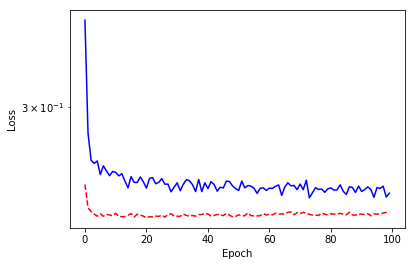

In [204]:
plot_loss(careful_bias_history,"Bias")

In [205]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_feats,
    y_train,
    batch_size=256,
    epochs=100,
    callbacks=[early_stopping],
    validation_data=(val_feats, y_val))

Epoch 1/100
111/111 [==============================] - 2s 7ms/step - loss: 0.3133 - tp: 96.0000 - fp: 59.0000 - tn: 30703.0000 - fn: 3531.0000 - accuracy: 0.8956 - precision: 0.6194 - recall: 0.0265 - auc: 0.7111 - prc: 0.2528 - val_loss: 0.2871 - val_tp: 18.0000 - val_fp: 4.0000 - val_tn: 5416.0000 - val_fn: 615.0000 - val_accuracy: 0.8977 - val_precision: 0.8182 - val_recall: 0.0284 - val_auc: 0.7721 - val_prc: 0.3476
Epoch 2/100
111/111 [==============================] - 0s 2ms/step - loss: 0.2933 - tp: 212.0000 - fp: 142.0000 - tn: 25200.0000 - fn: 2782.0000 - accuracy: 0.8968 - precision: 0.5989 - recall: 0.0708 - auc: 0.7608 - prc: 0.3120 - val_loss: 0.2827 - val_tp: 45.0000 - val_fp: 19.0000 - val_tn: 5401.0000 - val_fn: 588.0000 - val_accuracy: 0.8997 - val_precision: 0.7031 - val_recall: 0.0711 - val_auc: 0.7760 - val_prc: 0.3517
Epoch 3/100
111/111 [==============================] - 0s 2ms/step - loss: 0.2926 - tp: 209.0000 - fp: 163.0000 - tn: 25179.0000 - fn: 2785.0000 - ac

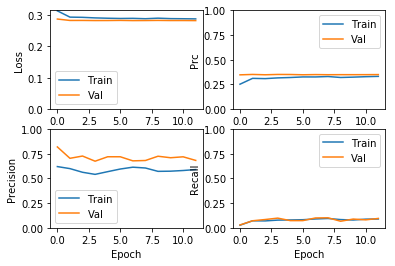

In [206]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[1], label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()
        
plot_metrics(baseline_history)

In [216]:
train_predictions_baseline = model.predict(train_feats)
test_predictions_baseline = model.predict(test_feats)


test_preds = []
test_probs = []
for i in test_predictions_baseline:
    if i > 0.5:
        test_preds.append(1)
        test_probs.append(i)
    
    else:
        test_preds.append(0)
        test_probs.append(i)


TP = sum([(p and l) for (p,l) in zip(test_preds, y_test)])
FP = sum([(p and not l) for (p,l) in zip(test_preds, y_test)])
TN = sum([(not p and not l) for (p,l) in zip(test_preds, y_test)])
FN = sum([(not p and l) for (p,l) in zip(test_preds, y_test)])
    
TPR = TP/(TP+FN)
TNR = TN/(TN+FP)
    
BER = 1 - .5 * (TPR + TNR)
    
precision = TP/(TP+FP)
recall = TP/(TP + FN)
    
F1 = 2 * (precision*recall)/(precision + recall)

accuracy = (TP + TN)/(TP + FP + TN + FN)

print(BER)


0.4643919054297736


In [208]:
"""Model learns to just pick zero since classes are so imbalanced"""


'Model learns to just pick zero since classes are so imbalanced'

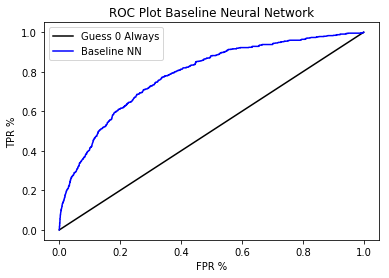

0.7843193462518248


In [228]:
from sklearn.metrics import roc_curve, roc_auc_score

r_probs = [0 for _ in range(len(y_test))]

r_auc = roc_auc_score(y_test,r_probs)
nn_auc = roc_auc_score(y_test,test_probs)

r_fpr,r_tpr,_ = roc_curve(y_test,r_probs)
nn_fpr,nn_tpr,_ = roc_curve(y_test,test_probs)



plt.plot(r_fpr,r_tpr, label = 'Guess 0 Always',color='black')
plt.plot(nn_fpr,nn_tpr, label = 'Baseline NN',color ='b')

plt.title('ROC Plot Baseline Neural Network')
plt.xlabel('FPR %')
plt.ylabel('TPR %')
plt.legend()
plt.show()

print(nn_auc)

In [210]:
"""Fix Class Imbalance"""

'Fix Class Imbalance'

In [211]:
weight_0 = (1/negative) * (positive+negative/2.0)
weight_1 = (1/positive) * (positive+negative/2.0)

class_weight = {0: weight_0, 1: weight_1}

print(weight_0)
print(weight_1)

0.6180258103738911
5.236361507843596


In [212]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_feats,
    y_train,
    batch_size=256,
    epochs=100,
    callbacks=[early_stopping],
    validation_data=(val_feats, y_val),
    class_weight=class_weight)

Epoch 1/100
111/111 [==============================] - 2s 8ms/step - loss: 0.9360 - tp: 657.0000 - fp: 2942.0000 - tn: 27820.0000 - fn: 2970.0000 - accuracy: 0.8281 - precision: 0.1826 - recall: 0.1811 - auc: 0.6025 - prc: 0.1501 - val_loss: 0.5263 - val_tp: 347.0000 - val_fp: 1231.0000 - val_tn: 4189.0000 - val_fn: 286.0000 - val_accuracy: 0.7494 - val_precision: 0.2199 - val_recall: 0.5482 - val_auc: 0.7456 - val_prc: 0.3125
Epoch 2/100
111/111 [==============================] - 0s 2ms/step - loss: 0.7016 - tp: 1657.0000 - fp: 6438.0000 - tn: 18904.0000 - fn: 1337.0000 - accuracy: 0.7256 - precision: 0.2047 - recall: 0.5534 - auc: 0.7191 - prc: 0.2583 - val_loss: 0.5305 - val_tp: 401.0000 - val_fp: 1265.0000 - val_tn: 4155.0000 - val_fn: 232.0000 - val_accuracy: 0.7527 - val_precision: 0.2407 - val_recall: 0.6335 - val_auc: 0.7728 - val_prc: 0.3481
Epoch 3/100
111/111 [==============================] - 0s 2ms/step - loss: 0.6899 - tp: 1706.0000 - fp: 6161.0000 - tn: 19181.0000 - fn: 

In [223]:
train_preds_weighted = weighted_model.predict(train_feats)
test_preds_weighted = weighted_model.predict(test_feats)


test_predictions_weighted = []
test_probs_weighted = []

for i in test_preds_weighted:
    if i > 0.5:
        test_predictions_weighted.append(1)
        test_probs_weighted.append(i)
    
    else:
        test_predictions_weighted.append(0)
        test_probs_weighted.append(i)
        


TP = sum([(p and l) for (p,l) in zip(test_predictions_weighted, y_test)])
FP = sum([(p and not l) for (p,l) in zip(test_predictions_weighted, y_test)])
TN = sum([(not p and not l) for (p,l) in zip(test_predictions_weighted, y_test)])
FN = sum([(not p and l) for (p,l) in zip(test_predictions_weighted, y_test)])
    
TPR = TP/(TP+FN)
TNR = TN/(TN+FP)
    
BER = 1 - .5 * (TPR + TNR)
    
precision = TP/(TP+FP)
recall = TP/(TP + FN)
    
F1 = 2 * (precision*recall)/(precision + recall)

accuracy = (TP + TN)/(TP + FP + TN + FN)

print("Balanced Error rate: " + str(BER))
print("Precision: " + str(precision))
print('Recall: ' + str(recall))
print('F1 score: ' + str(F1))
print('Total Classification Accuracy: ' + str(accuracy))

Balanced Error rate: 0.2871658986175115
Precision: 0.24156992813709233
Recall: 0.6785714285714286
F1 score: 0.3562984101100693
Total Classification Accuracy: 0.7398253419014664


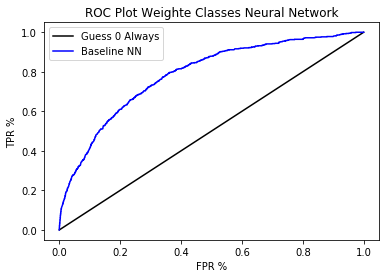

0.7851398231101696


In [227]:
r_probs = [0 for _ in range(len(y_test))]

r_auc = roc_auc_score(y_test,r_probs)
nn_auc = roc_auc_score(y_test,test_probs_weighted)

r_fpr,r_tpr,_ = roc_curve(y_test,r_probs)
nn_fpr,nn_tpr,_ = roc_curve(y_test,test_probs_weighted)



plt.plot(r_fpr,r_tpr, label = 'Guess 0 Always',color='black')
plt.plot(nn_fpr,nn_tpr, label = 'Baseline NN',color='b')

plt.title('ROC Plot Weighte Classes Neural Network')
plt.xlabel('FPR %')
plt.ylabel('TPR %')
plt.legend()
plt.show()

print(nn_auc)